# Raw data exploration

We chose ___TASK 1: Classification of Tabular Data___ from the list of projects.

In this notebook we will download the resource from the given [URL](https://grouplens.org/datasets/movielens/), in particular we are interested in the _[ml-latest.zip](https://files.grouplens.org/datasets/movielens/ml-latest.zip)_ archive that contains the following files:

- _genome-scores.csv_
- _genome-tags.csv_
- _links.csv_
- _movies.csv_
- _ratings.csv_
- _tags.csv_

After the __acquisition__ phase we will explore the content of each dataset, and we will perform some __pre-processing__ on them if necessary.

## Imports

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os

import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer

from src.data.acquisition import retrieve_movie_lens
from src.utils.const import DATA_DIR, RAW_CSV_NAMES, MOVIE_LENS_URL
from src.visualization.visualize import histplot

### Useful path to data

In [3]:
ROOT_DIR = os.path.join(os.getcwd(), '..')
RAW_DIR = os.path.join(ROOT_DIR, DATA_DIR, 'raw')

## Data Acquisition

We start by retrieving the all the raw datasets thanks to the function `retrieve_movie_lens(...) -> bool` that downloads the _.zip_ archive and decompress it inside the _data/raw_ folder. If all the _.csv_ files are already stored the function will do nothing.

In [4]:
if not retrieve_movie_lens(MOVIE_LENS_URL, RAW_DIR, RAW_CSV_NAMES):
    pass

No needed to download raw MovieLens data.
------------------------------


Now we are ready for the exploration, each of the following section is divided by dataset file name and has a small introduction taken from the [documentation](https://files.grouplens.org/datasets/movielens/ml-latest-README.html).

## movies.csv

Each line of this file after the header row represents one movie, where each one has __movieId__, __title__ and __genres__ as features. The __genres__ feature are a pipe-separated list from a fixed set of genres.

In [5]:
movies = pd.read_csv(
    os.path.join(RAW_DIR, 'movies.csv'),
    encoding='utf-8'
)

In [6]:
print(f'Movies dimensionality: {movies.shape}')

Movies dimensionality: (58098, 3)


### Data Pre-processing

In [7]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58098 entries, 0 to 58097
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  58098 non-null  int64 
 1   title    58098 non-null  object
 2   genres   58098 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.3+ MB


In [8]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


As we can see the types of some features are not correct, and in particular __movieId__ is over-sized for the range of values that it takes. We apply the right type for each feature.

In [9]:
movies = movies.astype(dtype={'movieId': 'int32', 'title': 'string', 'genres': 'category'})
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58098 entries, 0 to 58097
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   movieId  58098 non-null  int32   
 1   title    58098 non-null  string  
 2   genres   58098 non-null  category
dtypes: category(1), int32(1), string(1)
memory usage: 871.8 KB


This step is useful to decrease the size of the dataset in memory and improves the performance of futures operations. For these reasons we are going to perform the cast every time that is needed.

In order to understand better the nature of each single feature we try to discover more details.

In [10]:
movies['title'].head()

0                      Toy Story (1995)
1                        Jumanji (1995)
2               Grumpier Old Men (1995)
3              Waiting to Exhale (1995)
4    Father of the Bride Part II (1995)
Name: title, dtype: string

Analyzing the __title__ feature we noticed that we can extract two information:
- at the end of the title the launch year is provided
- since we are not going to use any NLP model, we transform the title into its string length

In [11]:
regex_year = '.*\\((\\d{4})\\).*'
movies['year'] = movies['title'].str.extract(pat=regex_year, expand=False)
movies['title_length'] = movies['title'].str.len()
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58098 entries, 0 to 58097
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   movieId       58098 non-null  int32   
 1   title         58098 non-null  string  
 2   genres        58098 non-null  category
 3   year          57771 non-null  string  
 4   title_length  58098 non-null  Int64   
dtypes: Int64(1), category(1), int32(1), string(2)
memory usage: 1.8 MB


In [12]:
movies = movies.astype(dtype={'year': 'float32', 'title_length': 'int32'})

In [13]:
print(f'Movies dimensionality after title analysis: {movies.shape}')

Movies dimensionality after title analysis: (58098, 5)


Analyzing the __genres__ feature we decided to encode each genre as a new feature. If in a row a genre is listed, the feature related to the genre will be 1, otherwise 0.

In [14]:
def encode_genre(df: pd.DataFrame) -> pd.DataFrame:
    genres = df['genres'].str.split('|')
    mlb = MultiLabelBinarizer()
    encoded_genre = pd.DataFrame(
        mlb.fit_transform(genres),
        index=df['movieId'],
        columns=mlb.classes_
    )
    return pd.merge(df, encoded_genre, on='movieId', how='inner')

In [15]:
movies = encode_genre(movies)
movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58098 entries, 0 to 58097
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   movieId             58098 non-null  int32   
 1   title               58098 non-null  string  
 2   genres              58098 non-null  category
 3   year                57771 non-null  float32 
 4   title_length        58098 non-null  int32   
 5   (no genres listed)  58098 non-null  int32   
 6   Action              58098 non-null  int32   
 7   Adventure           58098 non-null  int32   
 8   Animation           58098 non-null  int32   
 9   Children            58098 non-null  int32   
 10  Comedy              58098 non-null  int32   
 11  Crime               58098 non-null  int32   
 12  Documentary         58098 non-null  int32   
 13  Drama               58098 non-null  int32   
 14  Fantasy             58098 non-null  int32   
 15  Film-Noir           58098 non-null  

In [16]:
print(f'Movies dimensionality after genres encoding: {movies.shape}')

Movies dimensionality after genres encoding: (58098, 25)


### Data Cleaning

After the pre-processing phase we can now check if there are any NaN values, duplicates or rows with no information (eg. movies with no genre).

#### NaN values

In [17]:
movies.isna().sum()

movieId                 0
title                   0
genres                  0
year                  327
title_length            0
(no genres listed)      0
Action                  0
Adventure               0
Animation               0
Children                0
Comedy                  0
Crime                   0
Documentary             0
Drama                   0
Fantasy                 0
Film-Noir               0
Horror                  0
IMAX                    0
Musical                 0
Mystery                 0
Romance                 0
Sci-Fi                  0
Thriller                0
War                     0
Western                 0
dtype: int64

The __year__ feature has _327_ NaN values, in order to fill these values we have to check the distribution of the data.

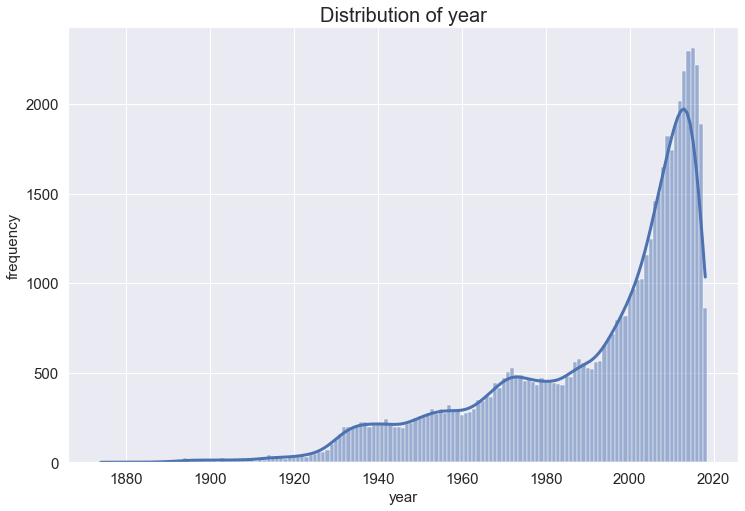

In [18]:
histplot(movies['year'],
         title='Distribution of year',
         xlabel='year',
         ylabel='frequency',
         stat='frequency',
         discrete=True,
         kde=True)

As we can see the distribution is skewed to the right, so we can fill the missing years' values with the median of the data.

In [19]:
median_year = movies['year'].median()
print(f"Median of year data: {median_year}")

Median of year data: 2001.0


In [20]:
movies = movies.fillna(value={'year': median_year})
movies = movies.astype(dtype={'year': 'int32'})

In [21]:
movies.isna().sum()

movieId               0
title                 0
genres                0
year                  0
title_length          0
(no genres listed)    0
Action                0
Adventure             0
Animation             0
Children              0
Comedy                0
Crime                 0
Documentary           0
Drama                 0
Fantasy               0
Film-Noir             0
Horror                0
IMAX                  0
Musical               0
Mystery               0
Romance               0
Sci-Fi                0
Thriller              0
War                   0
Western               0
dtype: int64

#### Duplicates

In [22]:
print(f'Duplicated samples: {movies[movies.duplicated()].shape[0]}')

Duplicated samples: 0


There are no duplicates, so we can go on with the cleaning process.

#### No information about genres

Inside the set of the given genres there is also _(no genres listed)_ that provide no additional information about the film. For this reason we decide to discard the films with this genre.

In [23]:
print(f"Movies with no genres listed: {movies[movies['(no genres listed)'] == 1].shape[0]}")

Movies with no genres listed: 4266


In [24]:
def remove_no_genres(df: pd.DataFrame) -> pd.DataFrame:
    df_no_genre = df[df['(no genres listed)'] == 1].index
    return df.drop(index=df_no_genre)

In [25]:
movies = remove_no_genres(movies)
print(f'Movies dimensionality after drop films with no genres: {movies.shape}')

Movies dimensionality after drop films with no genres: (53832, 25)


#### Drop elaborated features

We are now ready to drop no longer useful features like __title__, __genres__ and __(no genres listed)__.

In [26]:
movies = movies.drop(columns=['title', 'genres', '(no genres listed)'])

In [35]:
movies_shape_linear_exploration = movies.shape
print(f'Movies dimensionality after features drop: {movies_shape_linear_exploration}')

Movies dimensionality after features drop: (53832, 22)


### Summary

Finally, we can summarize each operation. We looked for the pandas best practices, and we found out that a good method to work with _DataFrame_ is to use the [Method Chaining](https://tomaugspurger.github.io/method-chaining.html).

In [28]:
# Read
movies = pd.read_csv(os.path.join(RAW_DIR, 'movies.csv'),
                     dtype={'movieId': 'int32', 'title': 'string', 'genres': 'category'},
                     encoding='utf-8')

# Pre-processing
movies = (movies
          .assign(year=movies['title'].str.extract(pat=regex_year, expand=False),
                  title_length=movies['title'].str.len())
          .astype({'year': 'float32', 'title_length': 'int32'})
          .pipe(encode_genre))

# Cleaning
movies = (movies
          .fillna({'year': movies['year'].median()})
          .astype({'year': 'int32'})
          .pipe(remove_no_genres)
          .drop(columns=['title', 'genres', '(no genres listed)']))

In [39]:
print(f'Final Movies dimensionality: {movies.shape}')
print(f'Match: {movies.shape == movies_shape_linear_exploration}')

Final Movies dimensionality: (53832, 22)
Match: True


## TODO: tags.csv, ratings.csv

### tags.csv

In [30]:
tags = pd.read_csv(
    os.path.join(RAW_DIR, 'tags.csv'),
    encoding='utf-8',
    usecols=['movieId', 'tag'],
    dtype={'movieId': 'int32', 'tag': 'string'}
)

tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1108997 entries, 0 to 1108996
Data columns (total 2 columns):
 #   Column   Non-Null Count    Dtype 
---  ------   --------------    ----- 
 0   movieId  1108997 non-null  int32 
 1   tag      1108981 non-null  string
dtypes: int32(1), string(1)
memory usage: 12.7 MB


#### Pipe tags

In [31]:
tags = (tags
        .groupby(by='movieId', as_index=False)['tag'].agg('count')
        .rename(columns={'tag': 'tag_count'})
        .astype({'movieId': 'int32', 'tag_count': 'int32'}))

tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45981 entries, 0 to 45980
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   movieId    45981 non-null  int32
 1   tag_count  45981 non-null  int32
dtypes: int32(2)
memory usage: 359.4 KB


### ratings.csv

In [32]:
ratings = pd.read_csv(
    os.path.join(RAW_DIR, 'ratings.csv'),
    encoding='utf-8',
    usecols=['movieId', 'rating'],
    dtype={'movieId': 'int32', 'rating': 'float32'}
)

ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27753444 entries, 0 to 27753443
Data columns (total 2 columns):
 #   Column   Dtype  
---  ------   -----  
 0   movieId  int32  
 1   rating   float32
dtypes: float32(1), int32(1)
memory usage: 211.7 MB


#### Pipe ratings

In [33]:
ratings = (ratings
           .groupby(by='movieId')['rating'].agg(['count', 'mean'])
           .reset_index()
           .rename(columns={'count': 'rating_count', 'mean': 'rating_mean'})
           .astype({'movieId': 'int32', 'rating_count': 'int32'}))

ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53889 entries, 0 to 53888
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   movieId       53889 non-null  int32  
 1   rating_count  53889 non-null  int32  
 2   rating_mean   53889 non-null  float32
dtypes: float32(1), int32(2)
memory usage: 631.6 KB
